In [4]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import math
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns
import operator
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

# Main file for attacking
Require:    
Attack_experiment.py  
attack_func.py  
MLclassifier.py  

In [2]:
from sklearn.preprocessing import KBinsDiscretizer
from Attack_experiment import unique_exam,compute_intersection,add_true_label,train_classifier
from attack_func import train_classifier,predict_prob,ordinal_encode,cut_dataset,sample_n
from MLclassifier import model_eval,train,evaluation,main
from sklearn import svm, datasets
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [ ]:
#plot figure 2
#load_adult(), load_lawschol(),load_compas
real,syn,sub_fake,sub_shadow = load_adult()
result =[]
for i in range(10):
    test = add_true_label(real,sub_fake[i])
    x = test[test['label']==1].freq.value_counts().to_frame().reset_index()
    x = x.rename(columns = {'index':'Freq','freq':'Counts'})
    x['index']=i
    x['member'] = 1
    result.append(x)
    
    x = test[test['label']==0].freq.value_counts().to_frame().reset_index()
    x = x.rename(columns = {'index':'Freq','freq':'Counts'})
    x['index']=i
    x['member'] = 0
    result.append(x)
result = pd.concat(result)

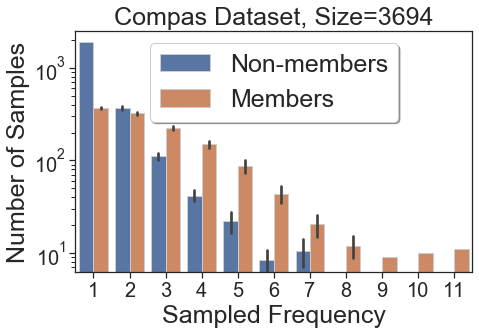

In [159]:
#sns.distplot(test["freq"], hue="label")

sns.set(style="ticks", color_codes=True,font_scale=1.5)
fig = plt.figure(figsize=(7, 5))
ax = sns.barplot(x='Freq',y = 'Counts',data = result ,edgecolor=".8", hue="member",log=True)
# Define some hatches
hatches = ['-', 'x']

# Loop over the bars
'''
for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    if i<8:
        thisbar.set_hatch(hatches[0])
    else:
        thisbar.set_hatch(hatches[1])
'''   
ax.set_title('Compas Dataset, Size=3694',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#ax.set_title('Lawsch Dataset, Size=43011',fontsize=25)
#ax.set_title('Adult Dataset, Size=31655',fontsize=25)
ax.set_ylabel('Number of Samples',fontsize=25)
ax.set_xlabel('Sampled Frequency',fontsize=25) 
legend = ax.legend(loc='upper center', shadow=True,fontsize=25) 
legend.texts[0].set_text("Non-members") 
legend.texts[1].set_text("Members") 
plt.tight_layout()
plt.savefig("./figure/"+"adv/"+ "compas_observation.png",dpi=300)

In [5]:
#compas
from sklearn.preprocessing import OrdinalEncoder,KBinsDiscretizer
def load_compas():
    discretizer = KBinsDiscretizer(n_bins=60, encode='ordinal', strategy='uniform')

    real = pd.read_csv('./GenerateData/Compas/Compas_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    real[['diff_custody','diff_jail']] = discretizer.fit_transform(real[['diff_custody','diff_jail']])

    syn = pd.read_csv('./GenerateData/Compas/Compas_syn_seed1_epo600_bs100.csv')
    syn = ordinal_encode(enc,syn)
    syn[['diff_custody','diff_jail']] = discretizer.transform(syn[['diff_custody','diff_jail']])
    sub_fake = cut_dataset(syn,10,3694)

    sub_shadow = []
    for i in range(10):
        tem = pd.read_csv('./GenerateData/Compas/Compas_shadow_v'+str(i)+'.csv')   
        tem = ordinal_encode(enc,tem)
        tem[['diff_custody','diff_jail']] = discretizer.transform(tem[['diff_custody','diff_jail']])
        sub_shadow.append(tem[:len(real)])
    return real,syn,sub_fake,sub_shadow

#shadow = pd.concat(sub_shadow,axis=0)

In [49]:
#lawschool
from sklearn.preprocessing import OrdinalEncoder,KBinsDiscretizer
def load_lawschol():
    discretizer = KBinsDiscretizer(n_bins=60, encode='ordinal', strategy='uniform')

    real = pd.read_csv('./GenerateData/lawschool/lawsch_train.csv') 
    enc = OrdinalEncoder()
    colomns = ['race','college','year']
    real[colomns] = enc.fit_transform(real[colomns])
    real['gpa'] = discretizer.fit_transform(real.values[:,1:2])

    syn = pd.read_csv('./GenerateData/lawschool/lawsch_syn_seed0.csv')
    syn['year'] = syn['year'].astype('object')
    syn[colomns] = enc.transform(syn[colomns])
    syn['gpa'] = discretizer.transform(syn.values[:,1:2])
    sub_fake = cut_dataset(syn,10,43011)

    sub_shadow = []
    for i in range(10):
        tem = pd.read_csv('./GenerateData/lawschool/lawsch_shadow_v'+str(i)+'.csv', dtype={'year': str})  
        tem['year'] = tem['year'].astype('object')
        tem[colomns] = enc.transform(tem[colomns])
        tem['gpa'] = discretizer.transform(tem.values[:,1:2])
        sub_shadow.append(tem)

    #shadow = pd.concat(sub_shadow,axis=0)
    return real,syn,sub_fake,sub_shadow

In [8]:
(0.7220-0.423)/0.7220

0.41412742382271467

In [9]:
(0.8723-0.8010)/0.8723

0.0817379341969505

In [50]:
real,syn,sub_fake,sub_shadow = load_lawschol()
sub_fake[2].shape,sub_shadow[2].shape

((43011, 8), (430110, 8))

In [1]:
from sklearn.preprocessing import OrdinalEncoder
def load_adult():
    real = pd.read_csv('./GenerateData/Adult/Adult_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)

    syn = pd.read_csv('./GenerateData/Adult/Adult_syn_seed1.csv')
    syn = ordinal_encode(enc,syn)
    sub_fake = cut_dataset(syn,10,31655)

    sub_shadow = []
    for i in range(10):
        tem = pd.read_csv('./GenerateData/Adult/Adult_shadow_v'+str(i)+'.csv')   
        sub_shadow.append(ordinal_encode(enc,tem))

    #shadow = pd.concat(sub_shadow,axis=0)
    return real,syn,sub_fake,sub_shadow

In [5]:
shadow = pd.read_csv('./GenerateData/Adult/DP/adult_shadow0_seed1_'+'z1.5.csv')
shadow.shape

(316550, 13)

In [27]:
def load_DP_adult():
    real = pd.read_csv('./GenerateData/Adult/Adult_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    
    test = pd.read_csv('./GenerateData/Adult/Adult_test.csv')
    test = ordinal_encode(enc,test)
    
    syn_list =[]
    shadow_list = []
    
    syn = pd.read_csv('./GenerateData/Adult/Adult_syn_seed1.csv')
    syn = ordinal_encode(enc,syn)
    sub_fake = cut_dataset(syn,10,31655)
    syn_list.append(sub_fake[0])
    shadow = pd.read_csv('./GenerateData/Adult/Adult_shadow_v0.csv')[:31655]
    shadow = ordinal_encode(enc,shadow)
    shadow_list.append(shadow)
    
    for z in {1.0,1.5,2.0,3.0,4.0,5.0}:
        syn = pd.read_csv('./GenerateData/Adult/DP/adult_syn_seed1_'+'z'+str(z)+'.csv')
        syn['Age'] = syn['Age'].astype('float').round(decimals=0)
        sub_fake = cut_dataset(syn,10,31655)
        syn_list.append(ordinal_encode(enc,sub_fake[0]))
        shadow = pd.read_csv('./GenerateData/Adult/DP/adult_shadow0_seed1_'+'z'+str(z)+'.csv')[:31655]
        shadow_list.append(ordinal_encode(enc,shadow))
    return real,test,syn_list,shadow_list
      

In [41]:
def load_DP_adult_for_ml(seed):
    real = pd.read_csv('./GenerateData/Adult/Adult_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    
    test = pd.read_csv('./GenerateData/Adult/Adult_test.csv')
    test = ordinal_encode(enc,test)
    
    syn_list =[]
    
    #syn = pd.read_csv('./GenerateData/Adult/Adult_syn_seed1.csv')
    #syn = ordinal_encode(enc,syn)[:31655]
    #sub_fake = cut_dataset(syn,10,31655)
    #syn_list.append(syn)
    for z in {1.0,1.5,2.0,3.0,4.0,5.0,10.5,21.0}:
        syn = pd.read_csv('./GenerateData/Adult/DP/adult_syn_seed'+str(seed)+'z'+str(z)+'.csv')
        syn['Age'] = syn['Age'].astype('float').round(decimals=0)
        sub_syn = syn[:31655]
        syn_list.append(ordinal_encode(enc,sub_syn))
    return test, syn_list
    

In [199]:
# load compas for ML, DP
from sklearn.preprocessing import OrdinalEncoder,KBinsDiscretizer



def load_DP_compas_forML(seed):
    real = pd.read_csv('./GenerateData/Compas/Compas_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    
    test = pd.read_csv("./GenerateData/Compas_test.csv")
    test = ordinal_encode(enc,test)
    
    syn_list =[]
    for z in {1.0,1.5,2.0,3.0,4.0,5.0,9.0,18.0,35.0}:
        syn = pd.read_csv('./GenerateData/Compas/DP/compas_syn_seed'+str(seed)+'z'+str(z)+'.csv')
        sub_syn = syn[:3694]
        syn_list.append(ordinal_encode(enc,sub_syn))
    return test, syn_list   
        

In [68]:
def load_DP_lawsch_for_ml(seed):
    real = pd.read_csv('./GenerateData/lawschool/lawsch_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    
    test = pd.read_csv('./GenerateData/lawschool/lawsch_test.csv')[:18434]
    test = ordinal_encode(enc,test)
    
    syn_list =[]
    
    #syn = pd.read_csv('./GenerateData/Adult/Adult_syn_seed1.csv')
    #syn = ordinal_encode(enc,syn)[:31655]
    #sub_fake = cut_dataset(syn,10,31655)
    #syn_list.append(syn)
    for z in {1.0,1.5,2.0,3.0,4.0,5.0,9.0,18.0}:
        syn = pd.read_csv('./GenerateData/lawschool/DP/lawsch_syn_seed'+str(seed)+'z'+str(z)+'.csv')
        #syn['Age'] = syn['Age'].astype('float').round(decimals=0)
        #sub_syn = syn[:31655]
        syn_list.append(ordinal_encode(enc,syn))
    return test, syn_list

In [19]:
def load_adult_epoches_for_ml(seed):
    real = pd.read_csv('./GenerateData/Adult/Adult_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    
    test = pd.read_csv('./GenerateData/Adult/Adult_test.csv')
    test = ordinal_encode(enc,test)
    
    syn_list =[]
    for i in range(23):
        if i<10:
            epoch = (i+1)*5
        else:
            epoch = (i-10)*20+60
        syn = pd.read_csv('./GenerateData/Adult/epoch'+str(seed)+'/adult_syn_seed1_'+'epoch'+str(epoch)+'.csv') 
        syn_list.append(ordinal_encode(enc,syn))
    return test, syn_list

In [66]:
from sklearn.preprocessing import Normalizer,OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
def preprocess_data(train,test,c_vars,label):
    data = pd.concat([train,test],axis=0)
    
    y = data[label]
    features = data.drop([label], axis=1)
    
    cat_vars = [col for col in features.columns if col not in c_vars]
    
    scaler = MinMaxScaler()
    features_c = scaler.fit_transform(features[c_vars])
    
    enc = OneHotEncoder()
    features[cat_vars] =features[cat_vars].astype('int')
    onehot = enc.fit_transform(features[cat_vars]).toarray()
    X =  np.concatenate((features_c,onehot ),axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.3, shuffle=False)
    return X_train, X_test, y_train, y_test 

In [ ]:
#evaluating machine learning models
from MLclassifier import model_eval,train,evaluation,main
#Adult
result=[]
epoches = [5,10,15,20,25,30,35,40,45,50,60,80,100,120,140,160,180,200,220,240,260,280,300]
for i in range(1,11):
    
    test, syn_list = load_adult_epoches_for_ml(seed = i)
    label='Income'
    c_vars = ['Age','HoursPerWeek','EducationNum']
    #test = pd.read_csv('./GenerateData/Adult/Adult_test.csv') 
    for epo,train in zip(epoches,syn_list):
        print("seed= %d, epoch = %d" %(i,epo)
        X_train, X_test, y_train, y_test = preprocess_data(train,test,c_vars,label)
        print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        overall_eval = main(X_train,y_train,X_test,y_test)
        overall_eval["models"] = overall_eval.index
        overall_eval["epoches"] = epo
        overall_eval["seed"] = i
        result.append(overall_eval)
result = pd.concat(result)  

In [187]:
result.to_csv('./exp_result/adult_epoches_for_ml.csv', index=False)

In [ ]:
#evaluating machine learning models vary different epsilon,adult
from MLclassifier import model_eval,train,evaluation,main
#Adult
result=[]
epsilon = [18.1,9.1,6.2,3.8,2.8,2.2,1.0,0.5]

for i in range(10):
    print("seed=",i)
    test, syn_list = load_DP_adult_for_ml(seed = i)
    label='Income'
    c_vars = ['Age','HoursPerWeek','EducationNum']
    #test = pd.read_csv('./GenerateData/Adult/Adult_test.csv') 
    for eps,train in zip(epsilon,syn_list):
        X_train, X_test, y_train, y_test = preprocess_data(train,test,c_vars,label)
        print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        overall_eval = main(X_train,y_train,X_test,y_test)
        overall_eval["models"] = overall_eval.index
        overall_eval["eps"] = eps
        overall_eval["seed"] = i
        result.append(overall_eval)
result = pd.concat(result)  
result.to_csv('./exp_result/adult_DP_for_ml.csv', index=False)

In [ ]:
#evaluating machine learning models vary different epsilon,lawschool
from MLclassifier import model_eval,train,evaluation,main

result=[]

epsilon = [15.0,7.8,5.3,3.3,2.4,1.9,1.0,0.5] 
for i in range(10):
    print("seed=",i)
    test, syn_list = load_DP_lawsch_for_ml(seed = i)
    label='admit'
    c_vars = ['lsat','gpa']
    #test = pd.read_csv('./GenerateData/Adult/Adult_test.csv') 
    for eps,train in zip(epsilon,syn_list):
        X_train, X_test, y_train, y_test = preprocess_data(train,test,c_vars,label)
        print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        overall_eval = main(X_train,y_train,X_test,y_test)
        overall_eval["models"] = overall_eval.index
        overall_eval["eps"] = eps
        overall_eval["seed"] = i
        result.append(overall_eval)
result = pd.concat(result)  
result.to_csv('./exp_result/lawsch_DP_for_ml.csv', index=False)

In [211]:
result.to_csv('./exp_result/lawsch_DP_for_ml.csv', index=False)

In [ ]:
#evaluating machine learning models vary different epsilon,compas
from MLclassifier import model_eval,train,evaluation,main

result=[]

epsilon = [36.3,17.6,11.6,6.9,4.9,3.8,2.0,1.0,0.5] 
for i in range(10):
    test, syn_list = load_DP_compas_forML(seed = i)
    label='two_year_recid'
    c_vars = ['age','diff_custody','diff_jail','priors_count']
    #test = pd.read_csv('./GenerateData/Adult/Adult_test.csv') 
    for eps,train in zip(epsilon,syn_list):
        print("seed= %d, epoch = %d" %(i,eps)
        X_train, X_test, y_train, y_test = preprocess_data(train,test,c_vars,label)
        print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        overall_eval = main(X_train,y_train,X_test,y_test)
        overall_eval["models"] = overall_eval.index
        overall_eval["eps"] = eps
        overall_eval["seed"] = i
        result.append(overall_eval)
result = pd.concat(result)  
result.to_csv('./exp_result/compas_DP_for_ml.csv', index=False)

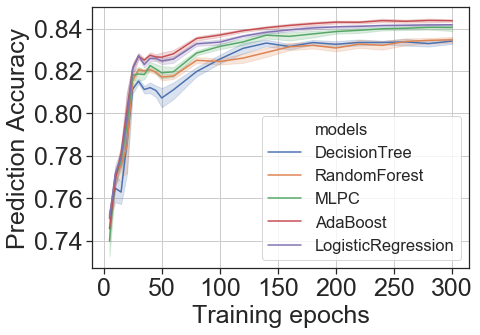

In [192]:
sns.set(style="ticks", color_codes=True,font_scale=1.5)
plt.figure(figsize=(7, 5))
#plt.title('Prediction Accuracy vary epoches, Adult',fontsize=25)


gragh = sns.lineplot(x="epoches", y="test_acc",hue='models',data=result)
plt.xlabel('Training epochs',fontsize=25)
plt.ylabel('Prediction Accuracy',fontsize=25)
plt.grid(True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig("./figure/"+"adv/"+ "Adult_epoches_MLAcc.png",dpi=300)

In [ ]:
sns.set(style="ticks", color_codes=True,font_scale=1.5)
plt.figure(figsize=(7, 5))
#plt.title('Prediction Accuracy vary epoches, Adult',fontsize=25)


gragh = sns.lineplot(x="eps", y="test_acc",hue='models',data=result)
plt.xlabel('Privacy Budget, Epsilon',fontsize=25)
plt.ylabel('Prediction Accuracy',fontsize=25)
plt.grid(True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
#plt.savefig("./figure/"+"adv/"+ "lawsch_DP_MLAcc.png",dpi=300)

In [172]:
from sklearn.preprocessing import OrdinalEncoder,KBinsDiscretizer
def load_DP_lawsch():
    discretizer = KBinsDiscretizer(n_bins=60, encode='ordinal', strategy='uniform')
    enc = OrdinalEncoder()
    colomns = ['race','college','year']
    
    real = pd.read_csv('./GenerateData/lawschool/lawsch_train.csv') 
    real[colomns] = enc.fit_transform(real[colomns])
    real['gpa'] = discretizer.fit_transform(real.values[:,1:2])
    
    syn_list =[]
    shadow_list = []
    
    syn = pd.read_csv('./GenerateData/lawschool/lawsch_syn_seed0.csv', dtype={'year': str})
    syn[colomns] = enc.transform(syn[colomns])
    syn['gpa'] = discretizer.transform(syn.values[:,1:2])
    sub_fake = cut_dataset(syn,10,43011)
    syn_list.append(sub_fake[0])
    
    tem = pd.read_csv('./GenerateData/lawschool/lawsch_shadow_v0.csv', dtype={'year': str})[:43011]
    tem[colomns] = enc.transform(tem[colomns])
    tem['gpa'] = discretizer.transform(tem.values[:,1:2])
    shadow_list.append(tem)
    
    
    for z in [1.0,1.5,2.0,3.0,4.0,5.0]:
        syn = pd.read_csv('./GenerateData/lawschool/DP/lawsch_syn_seed1_'+'z'+str(z)+'.csv', dtype={'year': str})
        sub_fake = cut_dataset(syn,10,43011)
        syn = sub_fake[0]
        syn[colomns] = enc.transform(syn[colomns])
        syn['gpa'] = discretizer.transform(syn.values[:,1:2])
        syn_list.append(syn)
        shadow = pd.read_csv('./GenerateData/lawschool/DP/lawsch_shadow0_seed1_'+'z'+str(z)+'.csv', dtype={'year': str})[:43011]
        shadow[colomns] = enc.transform(shadow[colomns])
        shadow['gpa'] = discretizer.transform(shadow.values[:,1:2])
        shadow_list.append(shadow)
    return real,syn_list,shadow_list

In [205]:
from sklearn.preprocessing import OrdinalEncoder,KBinsDiscretizer
def load_DP_compas(k):
    discretizer = KBinsDiscretizer(n_bins=60, encode='ordinal', strategy='uniform')
    #load real
    real = pd.read_csv('./GenerateData/Compas/Compas_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    real[['diff_custody','diff_jail']] = discretizer.fit_transform(real[['diff_custody','diff_jail']])
    
    syn_list =[]
    shadow_list = []
    
    # load synthetic data with no DP
    syn = pd.read_csv('./GenerateData/Compas/Compas_syn_seed1_epo600_bs100.csv')
    syn = ordinal_encode(enc,syn)
    syn[['diff_custody','diff_jail']] = discretizer.transform(syn[['diff_custody','diff_jail']])
    sub_fake = cut_dataset(syn,10,3694)
    syn_list.append(sub_fake[k])
    
    #load shadow dataset with no DP
    tem = pd.read_csv('./GenerateData/Compas/Compas_shadow_v'+str(k)+'.csv')   
    tem = ordinal_encode(enc,tem)
    tem[['diff_custody','diff_jail']] = discretizer.transform(tem[['diff_custody','diff_jail']])
    sub_shadow = cut_dataset(tem,10,3694)
    shadow_list.append(sub_shadow[k])
    
    #load synthetic data + shadow data with DP
    for z in [1.0,1.5,2.0,3.0,4.0,5.0]:
        print(z)
        syn = pd.read_csv('./GenerateData/Compas/DP/compas_syn_seed1_'+'z'+str(z)+'.csv')
        syn['age'] = syn['age'].round(decimals=0)
        syn['diff_custody'] = syn['diff_custody'].round(decimals=0)
        syn['priors_count'] = syn['priors_count'].round(decimals=0)
        sub_fake = cut_dataset(syn,10,3694)
        syn = sub_fake[0]
        syn = ordinal_encode(enc,syn)
        syn[['diff_custody','diff_jail']] = discretizer.transform(syn[['diff_custody','diff_jail']])
        syn_list.append(syn)
        
        shadow = pd.read_csv('./GenerateData/Compas/DP/compas_shadow0_seed1_'+'z'+str(z)+'.csv')
        shadow['age'] = shadow['age'].round(decimals=0)
        shadow['diff_custody'] = shadow['diff_custody'].round(decimals=0)
        shadow['priors_count'] = shadow['priors_count'].round(decimals=0)
        sub_fake = cut_dataset(shadow,10,3694)
        shadow = sub_fake[k]
        shadow = ordinal_encode(enc,shadow)
        shadow[['diff_custody','diff_jail']] = discretizer.transform(shadow[['diff_custody','diff_jail']])
        shadow_list.append(shadow)
    return real,syn_list,shadow_list

In [13]:
def load_epoches_adult(seed):
    real = pd.read_csv('./GenerateData/Adult/Adult_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    epoch =[10,20,30,40,50,100,140,200,240,300]
    syn_list =[]
    shadow_list = []
    
    for i in epoch:
        syn = pd.read_csv('./GenerateData/Adult/epoch'+str(seed)+'/adult_syn_seed1_'+'epoch'+str(i)+'.csv')
        syn = ordinal_encode(enc,syn)
        syn_list.append(syn)
        shadow = pd.read_csv('./GenerateData/Adult/epoch'+str(seed)+'/adult_shadow_seed1_'+'epoch'+str(i)+'.csv')
        shadow = ordinal_encode(enc,shadow)
        shadow_list.append(shadow)
    return real,syn_list,shadow_list

In [12]:

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
epoch =[10,20,30,40,50,100,140,200,240,300]

def compute_auc(real,syn_list,shadow_list):
    auc_list ={}
    result =[]
    for syn,shadow,epo in zip(syn_list,shadow_list,epoch):
        new_syn = add_true_label(real,syn)
        new_shadow = add_true_label(syn,shadow)
        classifier= train_classifier(new_shadow)
        precision, recall, thresholds1,auc = predict_prob(classifier,new_syn)
        #sample = sample_n(precision, recall, n=200)
        #sample_list.append(sample)
        auc_list['auc']= auc
        auc_list['epoch'] = epo
        auc_pd = pd.DataFrame([auc_list],index=[str(epo)])
        result.append(auc_pd)
    result = pd.concat(result)                              
    return result


In [ ]:
real,syn_list,shadow_list = load_epoches_adult(seed=1)
auc = compute_auc(real,syn_list,shadow_list)

In [ ]:
#compute AUC for different epochs
def compute_auc_result():
    auc_list = []
    for i in range(1,11):
        print("seed=", i)
        real,syn_list,shadow_list = load_epoches_adult(seed=i)
        auc = compute_auc(real,syn_list,shadow_list)
        auc['seed']=i
        auc_list.append(auc)
    auc_list = pd.concat(auc_list)
    return auc_list
auc_list = compute_auc_result()

In [18]:
auc_list.to_csv('./exp_result/adult_auc_epoch.csv', index=False)

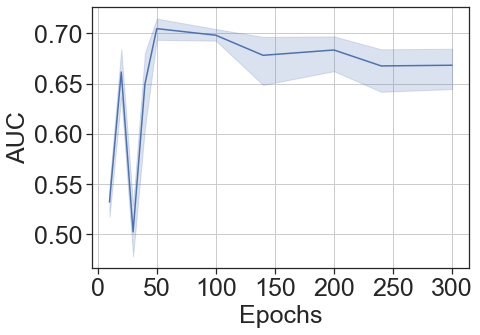

In [184]:
sns.set(style="ticks", color_codes=True,font_scale=1.5)
plt.figure(figsize=(7,5))
#plt.title('PR Curve Comparison, Adult',fontsize=25)

label =[10,20,30,40,50,100,140,200,240,300]
#plt.ylim(0.5,1)
#plt.xlim(0,1)
plt.grid(True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
sns.lineplot(x="epoch", y="auc",data=auc_list)
plt.xlabel('Epochs',fontsize=25)
plt.ylabel('AUC',fontsize=25)
#plt.plot(label, averaged_auc)
plt.tight_layout()
plt.savefig("./figure/"+"adv/"+ "adult_AUC_epoch.png",dpi=300)
plt.show()

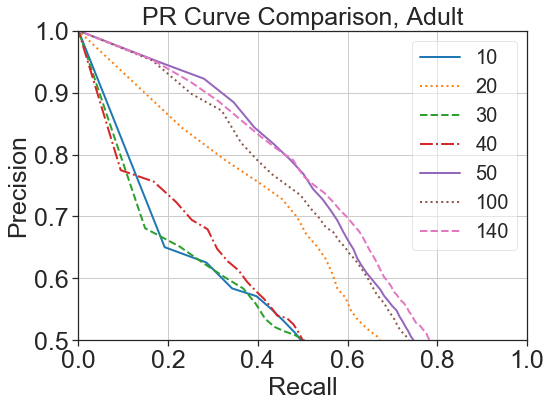

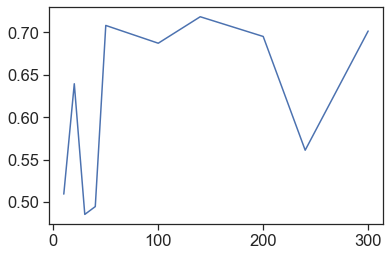

In [135]:
#plot noDP+ 6 PR curves
sns.set(style="ticks", color_codes=True,font_scale=1.5)
plt.figure(figsize=(8, 6))
plt.title('PR Curve Comparison, Adult',fontsize=25)
plt.xlabel('Recall',fontsize=25)
plt.ylabel('Precision',fontsize=25)
plt.ylim(0.5,1)
plt.xlim(0,1)
plt.grid(True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#Adult
#label = ['No DP','$\epsilon=18.1$','$\epsilon=9.1$','$\epsilon=6.2$'
   #      ,'$\epsilon=3.8$','$\epsilon=2.8$','$\epsilon=2.18$']
#lawschool    
#label = ['No DP','$\epsilon=15.0$','$\epsilon=7.77$','$\epsilon=5.32$'
#         ,'$\epsilon=3.30$','$\epsilon=2.40$','$\epsilon=1.89$']
#compas
#label = ['No DP','$\epsilon=36.3$','$\epsilon=17.6$','$\epsilon=11.6$'
#         ,'$\epsilon=6.91$','$\epsilon=4.94$','$\epsilon=3.84$']
#label = ['$N_e=50$','$N_e=100$','$N_e=150$','$N_e=200$'
#         ,'$N_e=250$','$N_e=300$']
label =[10,20,30,40,50,100,140,200,240,300]

linestyle_str = ['solid',      # Same as (0, ()) or '-'
     'dotted',    # Same as (0, (1, 1)) or '.'
     'dashed',   # Same as '--'
     'dashdot',
    'solid' , 
    'dotted',
    'dashed']
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',]

for sample,l,linestyle,c in zip(sample_list,label,linestyle_str,colors):
    plt.plot(sample[:,1],sample[:,0],linestyle=linestyle,label=l,color=c,linewidth='2')
    
plt.legend(loc='upper right',fontsize=20,fancybox=True, framealpha=0.5)
plt.tight_layout()
plt.savefig("./figure/"+"adv/"+ "adult_diff_epoch.png",dpi=300)
plt.show()



In [10]:

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#line1,base
#
auc_result = []
pre1= dict()
rec1  = dict()
pre10= dict()
rec10  = dict()
real,syn,sub_fake,sub_shadow = load_adult()
for idx in range(10):
    tem1 = {}
    new_sub_syn1 = add_true_label(real,sub_fake[idx])
    new_shadow1 = add_true_label(sub_fake[idx],sub_shadow[idx][:len(real)])
    print("training shape:%d, testing shape : %d"%(new_shadow1.shape[0],new_sub_syn1.shape[0]))
    classifier1= train_classifier(new_shadow1)
    pre1[idx], rec1[idx], thresholds1, auc = predict_prob(classifier1,new_sub_syn1)
    tem1['AUC'] = auc
    tem1['index'] = idx
    tem1['N_s']= 1
    tem1['data'] = 'adult'
    tem_pd = pd.DataFrame([tem1],index=[str(idx)])
    print(tem_pd)
    auc_result.append(tem_pd)
#sample1 = sample_n(precision1, recall1, n=200)
#line2: 3 times
    tem2 ={}
    combined_syn = add_true_label(real,syn)
    new_shadow =[]
    for i in range(10):
        tem = add_true_label(sub_fake[i],sub_shadow[i])
        new_shadow.append(tem)
    combined_shadow = pd.concat(new_shadow)
    print("training shape:%d, testing shape : %d"%(combined_shadow.shape[0],combined_syn.shape[0]))
    classifier2 = train_classifier(combined_shadow)
    pre10[idx], rec10[idx], thresholds2,auc2 = predict_prob(classifier2,combined_syn)
    tem2['AUC'] = auc2
    tem2['index'] = idx
    tem2['N_s']= 10
    tem2['data'] = 'adult'
    tem_pd2 = pd.DataFrame([tem2],index=[str(idx)])
    print(tem_pd2)
    auc_result.append(tem_pd2)
    #sample2 = sample_n(precision2, recall2, n=200)
auc_result = pd.concat(auc_result)

rec1_avg,pre1_avg = compute_average_PR(pre1, rec1)
rec10_avg, pre10_avg = compute_average_PR(pre10, rec10)

(28121, 13)
(28050, 13)
training shape:31655, testing shape : 31655
        AUC  index  N_s   data
0  0.684705      0    1  adult
(210698, 13)
(207302, 13)
(208600, 13)
(204194, 13)
(206327, 13)
(210445, 13)
(205593, 13)
(202883, 13)
(206839, 13)
(213516, 13)
(212661, 13)
training shape:3165500, testing shape : 316550
      AUC  index  N_s   data
0  0.7514      0   10  adult
(28089, 13)
(28070, 13)
training shape:31655, testing shape : 31655
        AUC  index  N_s   data
1  0.682187      1    1  adult
(210698, 13)
(207302, 13)
(208600, 13)
(204194, 13)
(206327, 13)
(210445, 13)
(205593, 13)
(202883, 13)
(206839, 13)
(213516, 13)
(212661, 13)
training shape:3165500, testing shape : 316550
        AUC  index  N_s   data
1  0.750877      1   10  adult
(28111, 13)
(27898, 13)
training shape:31655, testing shape : 31655
        AUC  index  N_s   data
2  0.539926      2    1  adult
(210698, 13)
(207302, 13)
(208600, 13)
(204194, 13)
(206327, 13)
(210445, 13)
(205593, 13)
(202883, 13)
(20683

C:\Users\HAT\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


       AUC  index  N_s   data
4  0.68102      4    1  adult
(210698, 13)
(207302, 13)
(208600, 13)
(204194, 13)
(206327, 13)
(210445, 13)
(205593, 13)
(202883, 13)
(206839, 13)
(213516, 13)
(212661, 13)
training shape:3165500, testing shape : 316550
        AUC  index  N_s   data
4  0.751766      4   10  adult
(28081, 13)
(28008, 13)
training shape:31655, testing shape : 31655
        AUC  index  N_s   data
5  0.675529      5    1  adult
(210698, 13)
(207302, 13)
(208600, 13)
(204194, 13)
(206327, 13)
(210445, 13)
(205593, 13)
(202883, 13)
(206839, 13)
(213516, 13)
(212661, 13)
training shape:3165500, testing shape : 316550
        AUC  index  N_s   data
5  0.748819      5   10  adult
(28066, 13)
(27706, 13)
training shape:31655, testing shape : 31655
        AUC  index  N_s   data
6  0.676968      6    1  adult
(210698, 13)
(207302, 13)
(208600, 13)
(204194, 13)
(206327, 13)
(210445, 13)
(205593, 13)
(202883, 13)
(206839, 13)
(213516, 13)
(212661, 13)
training shape:3165500, testing s

C:\Users\HAT\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


       AUC  index  N_s   data
7  0.67969      7    1  adult
(210698, 13)
(207302, 13)
(208600, 13)
(204194, 13)
(206327, 13)
(210445, 13)
(205593, 13)
(202883, 13)
(206839, 13)
(213516, 13)
(212661, 13)
training shape:3165500, testing shape : 316550
        AUC  index  N_s   data
7  0.749368      7   10  adult
(28070, 13)
(28403, 13)
training shape:31655, testing shape : 31655


C:\Users\HAT\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


        AUC  index  N_s   data
8  0.693928      8    1  adult
(210698, 13)
(207302, 13)
(208600, 13)
(204194, 13)
(206327, 13)
(210445, 13)
(205593, 13)
(202883, 13)
(206839, 13)
(213516, 13)
(212661, 13)
training shape:3165500, testing shape : 316550
        AUC  index  N_s   data
8  0.751231      8   10  adult
(27996, 13)
(28369, 13)
training shape:31655, testing shape : 31655
        AUC  index  N_s   data
9  0.667755      9    1  adult
(210698, 13)
(207302, 13)
(208600, 13)
(204194, 13)
(206327, 13)
(210445, 13)
(205593, 13)
(202883, 13)
(206839, 13)
(213516, 13)
(212661, 13)
training shape:3165500, testing shape : 316550
        AUC  index  N_s   data
9  0.748054      9   10  adult


NameError: name 'compute_average_PR' is not defined

In [16]:
rec1_avg,pre1_avg = compute_average_PR(pre1, rec1)
rec10_avg, pre10_avg = compute_average_PR(pre10, rec10)

In [15]:
def compute_average_PR(pre, rec):
    all_rec = np.unique(np.concatenate([rec[i] for i in range(10)]))

    mean_pre = np.zeros_like(all_rec)
    for i in range(10):
        mean_pre += np.interp(all_rec, np.flipud(rec[i]),np.flipud(pre[i]))
    mean_pre /= 10
    rec["macro"] = np.flipud(all_rec)
    pre["macro"] = np.flipud(mean_pre)
    return rec["macro"],pre["macro"] 
    

In [44]:
auc_Ns_adult = auc_result

In [51]:
#lawschool
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#line1,base
#
auc_result = []

real,syn,sub_fake,sub_shadow = load_lawschol()

for idx in range(10):
    tem1 = {}
    new_sub_syn1 = add_true_label(real,sub_fake[idx])
    new_shadow1 = add_true_label(sub_fake[idx],sub_shadow[idx][:len(real)])
    print("training shape:%d, testing shape : %d"%(new_shadow1.shape[0],new_sub_syn1.shape[0]))
    classifier1= train_classifier(new_shadow1)
    pre1[idx], rec1[idx], thresholds1, auc = predict_prob(classifier1,new_sub_syn1)
    tem1['AUC'] = auc
    tem1['index'] = idx
    tem1['N_s']= 1
    tem1['data'] = 'lawsch'
    tem_pd = pd.DataFrame([tem1],index=[str(idx)])
    print(tem_pd)
    auc_result.append(tem_pd)
#sample1 = sample_n(precision1, recall1, n=200)
#line2: 3 times
    tem2 ={}
    combined_syn = add_true_label(real,syn)
    new_shadow =[]
    for i in range(10):
        tem = add_true_label(sub_fake[i],sub_shadow[i])
        new_shadow.append(tem)
    combined_shadow = pd.concat(new_shadow)
    print("training shape:%d, testing shape : %d"%(combined_shadow.shape[0],combined_syn.shape[0]))
    classifier2 = train_classifier(combined_shadow)
    precision2, recall2, thresholds2,auc2 = predict_prob(classifier2,combined_syn)
    tem2['AUC'] = auc2
    tem2['index'] = idx
    tem2['N_s']= 10
    tem2['data'] = 'lawsch'
    tem_pd2 = pd.DataFrame([tem2],index=[str(idx)])
    print(tem_pd2)
    auc_result.append(tem_pd2)
    #sample2 = sample_n(precision2, recall2, n=200)
auc_Ns_lawsch = pd.concat(auc_result)

(35839, 8)
(35811, 8)
training shape:43011, testing shape : 43011
        AUC  index  N_s    data
0  0.599142      0    1  lawsch
(193877, 8)
(192990, 8)
(172591, 8)
(175449, 8)
(195104, 8)
(185891, 8)
(203554, 8)
(187718, 8)
(195519, 8)
(181297, 8)
(180896, 8)
training shape:4301100, testing shape : 430110
        AUC  index  N_s    data
0  0.649336      0   10  lawsch
(35897, 8)
(34356, 8)
training shape:43011, testing shape : 43011
        AUC  index  N_s    data
1  0.563733      1    1  lawsch
(193877, 8)
(192990, 8)
(172591, 8)
(175449, 8)
(195104, 8)
(185891, 8)
(203554, 8)
(187718, 8)
(195519, 8)
(181297, 8)
(180896, 8)
training shape:4301100, testing shape : 430110
        AUC  index  N_s    data
1  0.650535      1   10  lawsch
(35870, 8)
(34715, 8)
training shape:43011, testing shape : 43011
        AUC  index  N_s    data
2  0.582021      2    1  lawsch
(193877, 8)
(192990, 8)
(172591, 8)
(175449, 8)
(195104, 8)
(185891, 8)
(203554, 8)
(187718, 8)
(195519, 8)
(181297, 8)
(180

In [59]:
auc_Ns_lawsch = pd.concat(auc_result)

In [62]:
result = pd.read_csv("./exp_result/auc_Ns.csv")

In [65]:
compas = result[result['data']=="compas"]
adult = result[result['data']=="adult"]
new_result = pd.concat([adult,compas,auc_Ns_lawsch],axis=0)

In [71]:
#result = pd.concat([auc_Ns_compas,auc_Ns_lawsch,auc_Ns_adult],axis=0)
new_result.to_csv("./exp_result/auc_Ns.csv",index = False)

In [11]:
new_result = pd.read_csv("./exp_result/auc_Ns.csv")

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

sns.set_style(style="whitegrid")

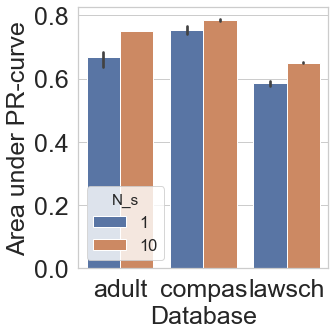

In [81]:
sns.set(style="whitegrid", color_codes=True,font_scale=1.5)
plt.figure(figsize=(5, 5))
sns.barplot(x="data", y="AUC", hue="N_s", data=new_result)
#plt.title('PR Curve Comparison, Compas',fontsize=25)
plt.xlabel('Database',fontsize=25)
plt.ylabel('Area under PR-curve',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
 #          ncol=2, mode="expand", borderaxespad=0.,fontsize=25)
#plt.legend(loc='upper center',)
plt.tight_layout()
#plt.savefig("./figure/"+"adv/"+ "one_ten_copies.png",dpi=300)
plt.show()

C:\Users\HAT\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


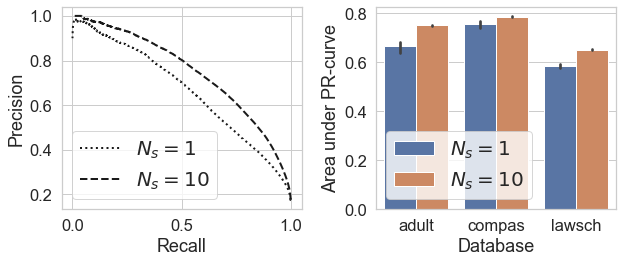

In [19]:
sns.set(style="whitegrid", color_codes=True,font_scale=1.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),constrained_layout=True)
axs[0].plot(rec1_avg,pre1_avg,'k:',label='$N_s=1$',linewidth='2')
axs[0].plot(rec10_avg,pre10_avg,'k--',label='$N_s=10$',linewidth='2')
#axs[0].set_ylim(0.5,1)
#axs[0].set_xlim(0.02,0.9)
axs[0].legend(loc='lower left',fontsize=20)
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')

g = sns.barplot(x="data", y="AUC", hue="N_s",data=new_result, ax =axs[1])
axs[1].set_xlabel('Database')
axs[1].set_ylabel('Area under PR-curve')
legend = g.legend(loc='lower left',fontsize=20) 
legend.texts[0].set_text("$N_s=1$") 
legend.texts[1].set_text("$N_s=10$")
#axs[1].legend(loc='lower left',fontsize=20)
plt.tight_layout()
plt.savefig("./figure/"+"adv/"+ "N_s_compare.png",dpi=300)

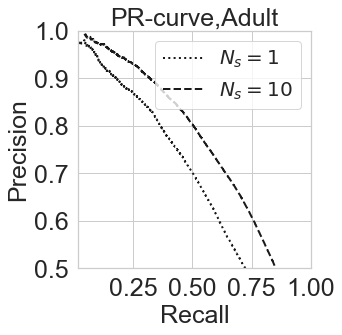

In [88]:
#plot comparison 
sns.set(style="whitegrid", color_codes=True,font_scale=1.5)
plt.figure(figsize=(5, 5))
plt.title('PR-curve,Adult',fontsize=25)
plt.xlabel('Recall',fontsize=25)
plt.ylabel('Precision',fontsize=25)
plt.ylim(0.5,1)
plt.xlim(0.02,1)
plt.grid(True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.plot(rec1_avg,pre1_avg,'k:',label='$N_s=1$',linewidth='2')
plt.plot(rec10_avg,pre10_avg,'k--',label='$N_s=10$',linewidth='2')
plt.legend(loc='upper right',fontsize=20)
plt.tight_layout()
#plt.savefig("./figure/"+"adv/"+ "compastencopies.png",dpi=300)
plt.show()

In [54]:
#compute 10 times PR curve for adult
from sklearn.preprocessing import OrdinalEncoder
from scipy import interp

def load_adult():
    real = pd.read_csv('./GenerateData/Adult/Adult_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    
    syn_list =[]
    shadow_list =[]
    for i in range(1,11):
        syn = pd.read_csv('./GenerateData/Adult/epoch'+str(i)+'/adult_syn_seed1_epoch300.csv')
        syn = ordinal_encode(enc,syn)
        syn_list.append(syn)
        
        shadow = pd.read_csv('./GenerateData/Adult/epoch'+str(i)+'/adult_shadow_seed1_epoch300.csv')
        shadow = ordinal_encode(enc,shadow)
        shadow_list.append(shadow)
    return real, syn_list,shadow_list

real, syn_list,shadow_list = load_adult()

def compute_PR_curve(real, syn_list,shadow_list):
    pre= dict()
    rec  = dict()
    for i in range(10):
        print("seed:", i)
        new_syn = add_true_label(real,syn_list[i])
        new_shadow = add_true_label(syn_list[i],shadow_list[i])
        classifier= train_classifier(new_shadow)
        pre[i], rec[i],_, _ = predict_prob(classifier,new_syn)
        #ample1 = sample_n(precision, recall, n=200)
        #ample = pd.DataFrame(sample1,columns=['precision','recall'])
        #ample['seed']=i
    all_rec = np.unique(np.concatenate([rec[i] for i in range(10)]))

    mean_pre = np.zeros_like(all_rec)
    for i in range(10):
        mean_pre += interp(all_rec, np.flipud(rec[i]),np.flipud(pre[i]))
    mean_pre /= 10
    rec["macro"] = np.flipud(all_rec)
    pre["macro"] = np.flipud(mean_pre)
    auc= metrics.auc(rec["macro"],pre["macro"])
    return pre,rec,auc

In [55]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve


#compute result
real, syn_list,shadow_list = load_adult()
pre_adult,rec_adult,auc_adult = compute_PR_curve(real, syn_list,shadow_list)
'''
real,syn,sub_fake,sub_shadow = load_lawschol()
pre_lawsch,rec_lawsch,auc_lawsch = compute_PR_curve(real, sub_fake,sub_shadow)
#new_sub_syn1 = add_true_label(real,sub_fake[0])
#new_shadow1 = add_true_label(sub_fake[0],sub_shadow[0][:len(real)])
#classifier2= train_classifier(new_shadow1)
#precision2, recall2, thresholds2 = predict_prob(classifier2,new_sub_syn1)
#sample2 = sample_n(precision2, recall2, n=200)

real,syn,sub_fake,sub_shadow = load_compas()
pre_compas,rec_compas,auc_compas = compute_PR_curve(real, sub_fake,sub_shadow)
#new_sub_syn1 = add_true_label(real,sub_fake[9])
#new_shadow1 = add_true_label(sub_fake[9],sub_shadow[9][:len(real)])
#classifier3= train_classifier(new_shadow1)
#precision3, recall3, thresholds3 = predict_prob(classifier3,new_sub_syn1)
#sample3 = sample_n(precision3, recall3, n=200)

'''

seed: 0
(28238, 13)
(28136, 13)
seed: 1
(28312, 13)
(28681, 13)
seed: 2
(28036, 13)
(28022, 13)
seed: 3
(28254, 13)
(28696, 13)
seed: 4
(28110, 13)
(28177, 13)
seed: 5
(28343, 13)
(28539, 13)


C:\Users\HAT\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


seed: 6
(28317, 13)
(28510, 13)
seed: 7
(27967, 13)
(27643, 13)


C:\Users\HAT\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


seed: 8
(28226, 13)
(27782, 13)
seed: 9
(28104, 13)
(28606, 13)


'\nreal,syn,sub_fake,sub_shadow = load_lawschol()\npre_lawsch,rec_lawsch,auc_lawsch = compute_PR_curve(real, sub_fake,sub_shadow)\n#new_sub_syn1 = add_true_label(real,sub_fake[0])\n#new_shadow1 = add_true_label(sub_fake[0],sub_shadow[0][:len(real)])\n#classifier2= train_classifier(new_shadow1)\n#precision2, recall2, thresholds2 = predict_prob(classifier2,new_sub_syn1)\n#sample2 = sample_n(precision2, recall2, n=200)\n\nreal,syn,sub_fake,sub_shadow = load_compas()\npre_compas,rec_compas,auc_compas = compute_PR_curve(real, sub_fake,sub_shadow)\n#new_sub_syn1 = add_true_label(real,sub_fake[9])\n#new_shadow1 = add_true_label(sub_fake[9],sub_shadow[9][:len(real)])\n#classifier3= train_classifier(new_shadow1)\n#precision3, recall3, thresholds3 = predict_prob(classifier3,new_sub_syn1)\n#sample3 = sample_n(precision3, recall3, n=200)\n\n'

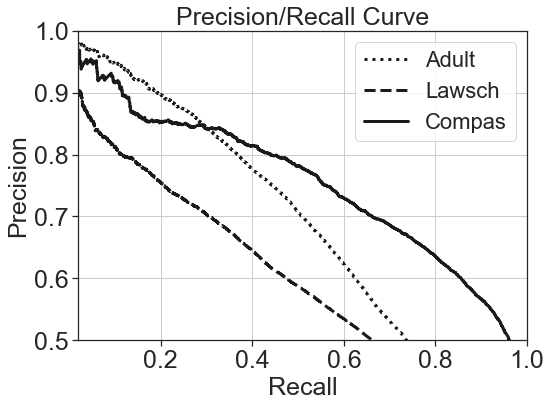

In [315]:
import matplotlib.pyplot as plt
#plt.rc('text',usetex=True)
#plt.rc('font',family='serif')

sns.set(style="ticks", color_codes=True,font_scale=1.5)

plt.figure(figsize=(8, 6))
#y_score = classifier.decision_function(X_test)

plt.title('Precision/Recall Curve',fontsize=25)
plt.xlabel('Recall',fontsize=25)
plt.ylabel('Precision',fontsize=25)
plt.ylim(0.5,1.0)
plt.xlim(0.02,1.0)
plt.grid(True)

plt.plot(rec_adult["macro"],pre_adult["macro"],'k:',label='Adult',linewidth='3')
plt.plot(rec_lawsch["macro"],pre_lawsch["macro"],'k--',label='Lawsch',linewidth='3')
plt.plot(rec_compas["macro"],pre_compas["macro"],'k',label='Compas',linewidth='3')

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(loc='upper right',fontsize=22)
plt.tight_layout()
plt.savefig("./figure/"+"adv/"+ "PRCurve.png",dpi=600)
plt.show()

In [1]:
rec_adult["macro"]

NameError: name 'rec_adult' is not defined

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True,font_scale=1.5)
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0.5,1.0)
plt.xlim(0.1,0.8)
plt.grid(True)

n=2
real,fake = load_real_fake(data='compas',num=n)
print(real.shape,fake.shape)
sub_fake = {}
rand_ind = np.random.permutation(len(real)*n)
for i in range(n):
    indices = rand_ind[n*i : n*i + len(real)]
    sub_fake[i] = fake.iloc[indices]
    
sub_fake_new = {}
for i in range(n):
    sub_fake_new[i] = add_true_label(real,sub_fake[i])

fake_new = pd.concat(sub_fake_new)
print("Overall trainset shape:",fake_new.shape)

classifier1= train_classifier(sub_fake_new[0])

classifier2= train_classifier(fake_new)

test = perpare_test(data='compas',num=n)

y_test = test.pop('label')
X_test = test.values

y_score = classifier1.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plt.plot(precision, recall,markeredgewidth='6',label='1')

y_score = classifier2.predict_proba(X_test)[:,1]  #test the classifier
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plt.plot(precision, recall,markeredgewidth='6',label='2')
plt.legend(loc='lower left',fontsize=18)


In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True,font_scale=1.5)


#y_score = classifier.decision_function(X_test)


plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0.5,1.0)
plt.xlim(0.1,0.8)
plt.grid(True)
dataset = ['adult','lawsch','compas']
for i in dataset:
    print("Dataset:",i)
    real,fake = load_train(data=i,num=1)  #load trainset
    fake1 = fake[:len(real)]
    fake2 = fake[len(real):]
    
    fake_new1 = add_true_label(real,fake1)   #add label to transet
    fake_new2 = add_true_label(real,fake2)
    fake_new = np.row_stack((fake_new1,fake_new2))
    print(fake_new.shape)
    classifier= train_classifier(fake_new)   #train the attack classifier   
    test = perpare_test(data=i,num=1) # load testset
    #test = test[0:3694]
    y_test = test.pop('label')
    X_test = test.values
    
    y_score = classifier.predict_proba(X_test)[:,1]  #test the classifier
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    plt.plot(recall,precision,markeredgewidth='6',label=i)
plt.legend(loc='lower left',fontsize=18)
plt.tight_layout()
plt.savefig("./figure/"+"adv/"+ "PRCurve.eps",dpi=600)
plt.show()


In [ ]:
precision, recall, thresholds

In [ ]:
recall[200]

In [ ]:
from plot_function import plot_compas_CDF

In [ ]:
#Experiment 1
attack = attack_experiment(data='Adult',size=10)
attack.add_true_label()
#true,table = attack.add_guess_label(threshold=4)
#avg = attack.classifier(drop_count=0,adv_flag=0,seed=1)
#avg

In [ ]:
#Experiment 2
attack = attack_experiment(data='compas')
attack.add_true_label()
true,table = attack.add_guess_label(threshold=2)
avg = attack.classifier(drop_count=0,adv_flag=0)

In [ ]:
fake1 = pd.read_csv("./GenerateData/lawschool/lawch_syn_43011.csv")
fake1.shape

In [ ]:
tem=[]
for thre in range(2,6):
    print("thre=",thre)
    attack = attack_experiment(data='Adult',size=1)
    attack.add_true_label()
    true,table = attack.add_guess_label(threshold=thre)
    avg = attack.classifier(drop_count=0,adv_flag=1,seed=3)
    tem.append(avg)
pd.DataFrame(tem,index=np.arange(2,6))

In [ ]:
tem=[]
for thre in range(15,20):
    print("thre=",thre)
    attack = attack_experiment(data='compas',size=9)
    attack.add_true_label()
    true,table = attack.add_guess_label(threshold=thre)
    avg = attack.classifier(drop_count=0,adv_flag=1,seed=3)
    tem.append(avg)
pd.DataFrame(tem,index=np.arange(15,20))

In [ ]:
tem=[]
for thre in range(16,22):
    print("thre=",thre)
    attack = attack_experiment(data='compas',size=10)
    attack.add_true_label()
    true,table = attack.add_guess_label(threshold=thre)
    avg = attack.classifier(drop_count=0,adv_flag=1,seed=3)
    tem.append(avg)
pd.DataFrame(tem,index=np.arange(16,22))

In [ ]:
tem=[]
for thre in range(12,17):
    print("thre=",thre)
    attack = attack_experiment(data='compas',size=7)
    attack.add_true_label()
    true,table = attack.add_guess_label(threshold=thre)
    avg = attack.classifier(drop_count=0,adv_flag=1,seed=3)
    tem.append(avg)
pd.DataFrame(tem,index=np.arange(12,17))

In [ ]:
pd.DataFrame(tem,index=np.arange(2,7))

In [ ]:
attack = attack_experiment(data='Adult')

In [ ]:
attack.add_true_label()

In [ ]:
attack.fake.head()

In [ ]:
518/1163

In [ ]:
real_part = attack.fake[attack.fake['true_label']==1]

In [ ]:
a= attack.fake[attack.fake['freq']>6]
x = a[a['true_label']==1]
x= x[x['counts_in_real']==1].sort_values(by=['freq'], ascending=False)

In [ ]:
#a = attack.fake[attack.fake['freq']>6]
x = a[a['counts_in_real']==1].sort_values(by=['freq'], ascending=False)

In [ ]:
counter, _=attack.unique_exam(real_part)
print("Real: unique per:%.4f \t less than three:%.4f" % 
                (counter[0][1]/real_part.shape[0],(counter[0][1]+counter[1][1]+counter[2][1])/real_part.shape[0]))
            

In [ ]:
true,table = attack.add_guess_label(threshold=2)

In [ ]:
avg = attack.classifier(drop_count=1,adv_flag=0)
avg

In [ ]:
attack.fake['freq'].quantile(0.82)

In [ ]:
x = attack.fake[attack.fake['freq']>3]

In [ ]:
x

In [ ]:
print(x.shape[0],x.shape[0]/attack.fake.shape[0])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
venn2(subsets = (31655, 31655, 5250), set_labels = ('real', 'synthetic'))
plt.savefig("./figure/venn1.eps",dpi=600,format='eps')

In [ ]:
x = true[true['counts_in_real']==1].sort_values(by=['freq'], ascending=False)
x['IdxInReal']=IdxInReal
#x.to_csv('./GenerateData/experiment/ex1.csv', index=True)

In [ ]:
#find IdxInReal
def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]
tem=[]
for i in x.index:
    target = attack.fake1_new.iloc[i].values
    idx = findByRow(attack.real_new.values, target)
    tem.append(idx)
IdxInReal = np.concatenate(tem, axis=0) 

In [ ]:
x['IdxInReal']=IdxInReal

In [ ]:
x

In [ ]:
list_ = []
for i in range(1,6):
    print("thre=",i)
    _, table = attack.add_guess_label(threshold=i)
    list_.append(table)
table_sum = pd.concat(list_, axis = 0)
table_sum

In [ ]:
avg = attack.classifier( drop_count=0 )

In [ ]:
avg

In [ ]:
data = data[data['true_label']==1]

In [ ]:
data.shape

In [ ]:
data['compare']= data[["true_label","guess_label"]].apply(lambda x: x["true_label"] == x["guess_label"],axis=1)

In [ ]:
result = data['compare'].value_counts()
result

In [ ]:
def unique_exam(data):
    uniques,counts = np.unique(data.values,axis=0,return_counts=True)
    return Counter(counts).most_common(80), uniques

x1, uniques_r = unique_exam(real_new)
print(x1)
x2, uniques_f1 = unique_exam(fake1_new)
print(x2)
x3, uniques_f2 = unique_exam(fake2_new)
print(x3)

In [ ]:
def compute_intersection(data1,data2):
    x = np.concatenate((data1, data2), axis=0)
    _,index,counts = np.unique(x,axis=0,return_index = True,return_counts=True)
    print('重复次数:',Counter(counts))
    idx = []
    for i,count in enumerate(counts):
        if count==2:
            idx.append(index[i])
    duplicate = x[idx]
    return duplicate

In [ ]:
duplicate = compute_intersection(uniques_f1,uniques_f2)

In [ ]:
duplicate.shape

In [ ]:
fake_new, per = compute_counts_in_real(duplicate, real_new)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(fake_new[:,-1])

In [ ]:
real = attack.real_new
fake = attack.fake_new

In [ ]:
fake1 = fake[:real.shape[0]]
fake2 = fake[real.shape[0]:2*real.shape[0]]
fake3 = fake[2*real.shape[0]:3*real.shape[0]]
fake4 = fake[3*real.shape[0]:4*real.shape[0]]
fake5 = fake[4*real.shape[0]:]

In [ ]:
def unique_exam(data):
    uniques,counts = np.unique(data.values,axis=0,return_counts=True)
    print(uniques.shape)
    return uniques

fake1_u = unique_exam(fake1)
fake2_u = unique_exam(fake2)
fake3_u = unique_exam(fake3)
fake4_u = unique_exam(fake4)
fake5_u = unique_exam(fake5)

In [ ]:
#compute the intersection of two datasets, return intersection data duplicate
def compute_intersection(data1,data2):
    x = np.concatenate((data1, data2), axis=0)
    uniques,index,counts = np.unique(x,axis=0,return_index = True,return_counts=True)
    print('重复次数:',Counter(counts))
    idx = []
    for i,count in enumerate(counts):
        if count==2:
            idx.append(index[i])
    duplicate = x[idx]
    return duplicate
    
inter12 = compute_intersection(fake1_u,fake2_u)
inter123 = compute_intersection(inter12,fake3_u)
inter1234 = compute_intersection(inter123,fake4_u)
inter12345 = compute_intersection(inter1234,fake5_u)

In [ ]:
def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]

def compute_counts_in_real(fake, real):
    count = []
    i=0
    for item in fake:
        x = findByRow(real.values,item)
        c = x.shape[0]
        if c is not 0:
            i = i+1
        count.append(c)
    c_ = np.array(count).reshape(-1,1)
    fake_new = np.concatenate((fake,c_),axis=1)
    #fake_new_pd = pd.DataFrame(fake_new,index=None,columns=['lsat', 'gpa', 'race', 'college', 'year', 'gender', 'resident',
     #  'admit','count'])
    return fake_new, i/fake.shape[0]

In [ ]:
fake_new,fake_new_pd, per = compute_counts_in_real(inter12345, real)

In [ ]:
per

In [ ]:
fake_new_pd.head(30)

In [ ]:
fake_new_pd['count'].value_counts()

In [ ]:
def sample_membership_data(data):
    tem1 = data[(data["ture_label"])==1].values
    data_np = data.values
    datalist = []
    for i in range(1000):
        a = np.random.randint(0,2)
        if a==0:
            a2 = np.random.randint(0,len(tem1))
            data_i = tem1[a2]
        else:
            a2 = np.random.randint(0,len(data_np))
            data_i = data_np[a2]
        datalist.append(data_i)
    data_j = np.array(datalist)
    data_pd = pd.DataFrame(data_j,index=None, columns = data.columns)
    return data_pd

In [ ]:
def compute_advantage(data):
    
    data_pd = sample_membership_data(data)
    
    tem0 = data_pd[(data_pd["ture_label"])==0]
    tem1 = data_pd[(data_pd["ture_label"])==1]
    
    x = tem1['guess_label'].value_counts(normalize=True)
    tpr = x[1]

    x = tem0['guess_label'].value_counts(normalize=True)
    fpr = x[1]
    adv = round(tpr - fpr,4)
    return tpr,fpr,adv
    

In [ ]:
tpr,fpr,adv = compute_advantage(attack.fake)
tpr,fpr,adv

In [ ]:
sns.countplot(fake_label_high['ture_label'])
x = fake_label_high['ture_label'].value_counts(normalize=True)
print(x)


In [ ]:
sns.countplot(fake_label_low['ture_label'])
x= fake_label_low['ture_label'].value_counts(normalize=True)
print(x)

In [ ]:
sns.swarmplot(x='ture_label',y='freq',data=attack.fake[1500:2000])

In [ ]:
max_,freq_  = find_best_freq_thre(attack.fake)
max_,freq_

In [ ]:
freq_thre = attack.fake['freq'].quantile(0.5)
freq_thre

In [ ]:
def find_best_freq_thre(fake_label):
    max_ = 0
    freq_ =0
    for i in range(1,math.ceil(fake_label['freq'].quantile(0.9))):
        fake_label_high = fake_label[(fake_label['freq']> i )] 
        fake_label_low = fake_label[(fake_label['freq']<= i)]
        per = fake_label_high.shape[0]/(fake_label_high.shape[0]+ fake_label_low.shape[0])
        x_high = fake_label_high['ture_label'].value_counts(normalize=True)[1]
        x_low = fake_label_low['ture_label'].value_counts(normalize=True)[1]
        item = x_high*per-x_low*(1-per)
        if (item>max_):
            max_ = item
            freq_ = i
    return max_,freq_ 

In [ ]:
#real data信息
def unique_exam(data):
    uniques,index,counts = np.unique(data.values,axis=0,return_index = True,return_counts=True)
    return Counter(counts).most_common(80), uniques


In [ ]:
counter, uniques = unique_exam(attack.real_new)
print(counter)

In [ ]:
3694*0.3008*0.4


In [ ]:
real = pd.read_csv("./GenerateData/lawschool/lawschool_tain.csv")
print(real.shape)

In [ ]:
fake1 = pd.read_csv("./GenerateData/lawschool/trainset43011_different/fake1.csv")
fake2 = pd.read_csv("./GenerateData/lawschool/trainset43011_different/fake2.csv")
fake3 = pd.read_csv("./GenerateData/lawschool/trainset43011_different/fake3.csv")
fake4 = pd.read_csv("./GenerateData/lawschool/trainset43011_different/fake4.csv")
fake5 = pd.read_csv("./GenerateData/lawschool/trainset43011_different/fake5.csv")


In [ ]:
inter12 = compute_intersection(fake1_u,fake2_u)

In [ ]:
inter12.shape

In [ ]:
discretizer.bin_edges_[0][55]

In [ ]:
match_real = real_new[(real_new.race==2.0) & (real_new.college==15.0) & (real_new.year==0.0) & (real_new.gender==1.0)
         & (real_new.resident==0.0) & (real_new.admit == 0.0)]

In [ ]:

Alice = real[(real.race==2.0) & (real.college==15.0) & (real.year==0.0) & (real.gender==1.0)
         & (real.resident==0.0) & (real.admit == 0.0)]

In [ ]:
match = real_of_intersection_pd[(real_of_intersection_pd.race==2.0) & (real_of_intersection_pd.college==15.0) & (real_of_intersection_pd.year==0.0) & (real_of_intersection_pd.gender==1.0)
         & (real_of_intersection_pd.resident==0.0) & (real_of_intersection_pd.admit == 0.0)]

In [ ]:
real_new = data[:43011]
print(real_new.shape)
fake1_new = data[43011:43011*2]
print(fake1_new.shape)
fake2_new = data[43011*2:43011*3]
print(fake2_new.shape)
fake3_new = data[43011*3:43011*4]
print(fake2_new.shape)
fake4_new = data[43011*4:43011*5]
print(fake2_new.shape)
fake5_new = data[43011*5:]
print(fake2_new.shape)

In [ ]:
#real
info_real,uniques_real = unique_exam(real_new)
print(real.shape)
print(info_real)
print(uniques_real.shape)

In [ ]:
#连接多个fake data
fake_new = pd.concat([fake1_new,fake2_new,fake3_new,fake4_new, fake5_new],axis=0)
print(fake_new.shape)

In [ ]:
fake_new = fake2_new

添加重复次数count和是否real

In [ ]:
fake_new.head()

In [ ]:
fake_count_pd.head()

In [ ]:
def add_count_label(fake_new):
    unique, index, inverse_index,count = np.unique(fake_new,axis=0, return_index=True, return_inverse=True, return_counts=True)
    fake = pd.DataFrame(unique[inverse_index],columns = real.columns)
    fake['count'] = count[inverse_index].reshape(-1,1)
    
    return fake

In [ ]:
unique, index, inverse_index,count = np.unique(fake_new,axis=0, return_index=True, return_inverse=True, return_counts=True)
fake_count_pd = pd.DataFrame(unique[inverse_index],columns = real.columns)
fake_count_pd['count'] = count[inverse_index].reshape(-1,1)

添加label：是否是real data

In [ ]:
print("fake_unique:", unique.shape)
real_fake1 = compute_intersection(unique,uniques_real)
print("intersection of fake_unique and real_unique:", real_fake1.shape)
test_data = np.concatenate((unique,real_fake1), axis=0) 
unique2,count2 = np.unique(test_data,axis=0, return_counts=True)
d_count = count2-1
print(d_count.shape)
real_fake_label = (d_count[inverse_index] >0)
print(real_fake_label.shape)

In [ ]:
fake_count_pd['real?'] = real_fake
fake_count_pd['real?'] = fake_count_pd['real?'].astype('int')

In [ ]:
print(fake_count_pd['real?'].value_counts())
sns.countplot(fake_count_pd['real?'])

In [ ]:
fake_count_pd.to_csv('fake3_add_label.csv', index=False)

画图表示pearson correlation coefficient

In [ ]:
sns.heatmap(fake_count_pd.corr(), square=True,cmap="YlGnBu",annot=True)


In [ ]:
fake_count_pd = pd.read_csv('fake3_add_label.csv')

In [ ]:
#fake_count_pd = fake_count_pd.drop(columns=['count'])
label = fake_count_pd.pop('real?').values

features = fake_count_pd.values
print(label.shape,features.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features ,label, test_size=0.3, random_state=2)

训练一个分类器，认识哪个是real，哪个是fake

In [ ]:
def model_eval(actual,pred):
    out={}
    out['accuracy']  =  round(metrics.accuracy_score(actual, pred)*100,2)
    out['precision'] =  round(metrics.precision_score(actual, pred)*100,2)
    out['recall']    =  round(metrics.recall_score(actual, pred)*100,2)
    out['f1_score']  =  round(metrics.f1_score(actual, pred)*100,2)
    
    return out

In [ ]:
from sklearn.neural_network import MLPClassifier
result = []
for i in range(10):
    mlp = MLPClassifier(hidden_layer_sizes=(50, ),max_iter = 200)
    mlp.fit(X_train, y_train)
    y_predict = mlp.predict(X_test)
    result.append(model_eval(y_test, y_predict))
print(result)

In [ ]:
avg={}
avg['accuracy']=0
avg['precision'] = 0
avg['recall'] =0
avg['f1_score'] =0
for i in range(10):
    avg['accuracy'] += result[i]['accuracy']
    avg['precision'] += result[i]['precision']
    avg['recall'] += result[i]['recall']
    avg['f1_score'] += result[i]['f1_score']
avg['accuracy'] = round(avg['accuracy'] /10,2)
avg['precision'] = round(avg['precision'] /10,2)
avg['recall'] = round(avg['recall'] /10,2)
avg['f1_score'] = round(avg['f1_score'] /10,2)
print(avg)    

In [ ]:
#fake1
info_fake1,uniques_fake1 = unique_exam(fake1_new)
print(fake1.shape)
print(info_fake1)
print(uniques_fake1.shape)

#fake2
info_fake2,uniques_fake2 = unique_exam(fake2_new)
print(fake2.shape)
print(info_fake2)
print(uniques_fake2.shape)

#fake3
info_fake3,uniques_fake3 = unique_exam(fake3_new)
print(fake3.shape)
print(info_fake3)
print(uniques_fake3.shape)

info_fake4,uniques_fake4 = unique_exam(fake4_new)
print(fake4.shape)
print(info_fake4)
print(uniques_fake4.shape)

info_fake5,uniques_fake5 = unique_exam(fake5_new)
print(fake5.shape)
print(info_fake5)
print(uniques_fake5.shape)

In [ ]:
count.shape

In [ ]:
fake = [uniques_fake1,uniques_fake2,uniques_fake3,uniques_fake4,uniques_fake5]
per_sum=0
for syn in fake:
    inter = compute_intersection(uniques_real,syn)
    len_ = syn.shape[0]
    per = round(inter.shape[0]/len_*100,2)
    per_sum += per
    print("Shape of intersection{},pencentage:{}"
      .format(inter.shape[0], per))
print("average percentage={}".format(round(per_sum/5,2)))

In [ ]:
real_fake1 = compute_intersection(uniques_fake1,uniques_real)
#real_of_real_fake1 = compute_intersection(uniques_real,du_fake12)
print("Shape of intersection{},pencentage:{}"
      .format(real_fake1.shape,real_fake1.shape[0]/uniques_fake1.shape[0]))

In [ ]:
du_fake12 = compute_intersection(uniques_fake1,uniques_fake2)
real_of_du_fake12 = compute_intersection(uniques_real,du_fake12)
print("Number of intersection:{}, real:{}({})"
      .format(du_fake12.shape,real_of_du_fake12.shape[0],round(real_of_du_fake12.shape[0]/du_fake12.shape[0]*100,2)))

du_fake123 = compute_intersection(du_fake12,uniques_fake3)
real_of_du_fake123 = compute_intersection(uniques_real,du_fake123)
print("Number of intersection:{}, real:{}({})"
      .format(du_fake123.shape,real_of_du_fake123.shape[0],round(real_of_du_fake123.shape[0]/du_fake123.shape[0]*100,2)))

du_fake1234 = compute_intersection(du_fake123,uniques_fake4)
real_of_du_fake1234 = compute_intersection(uniques_real,du_fake1234)
print("Number of intersection:{}, real:{}({})"
      .format(du_fake1234.shape,real_of_du_fake1234.shape[0],round(real_of_du_fake1234.shape[0]/du_fake1234.shape[0]*100,2)))

du_fake12345 = compute_intersection(du_fake1234,uniques_fake5)
real_of_du_fake12345 = compute_intersection(uniques_real,du_fake12345)
print("Number of intersection:{}, real:{}({})"
      .format(du_fake12345.shape[0],real_of_du_fake12345.shape[0],round(real_of_du_fake12345.shape[0]/du_fake12345.shape[0]*100,2)))

In [ ]:
uniques_real_pd = pd.DataFrame(uniques_real,columns = real.columns)

In [ ]:
real_of_intersection_pd = pd.DataFrame(real_of_du_fake12345,columns = real.columns)

In [ ]:
uniques_fake1_pd = pd.DataFrame(uniques_fake1,columns = real.columns)

In [ ]:
uniques_real_pd.head()

In [ ]:
sns.countplot(uniques_real_pd["college"])
plt.show()

In [ ]:
uniques_fake1_pd.head()

In [ ]:
sns.countplot(uniques_fake1_pd["college"])
plt.show()

In [ ]:
real_of_intersection_pd.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(real_of_intersection_pd["college"])
plt.show()

In [ ]:
#计算最后定位到的real of fake1234 data当中在real data当中的唯一性，判断攻击危害
data_c= [real_fake1,real_of_du_fake12,real_of_du_fake123,real_of_du_fake1234,real_of_du_fake12345]
for data_i in data_c:
    test2 = np.concatenate((data_i, real_new.values), axis=0) 
    unique, index, inverse_index,count = np.unique(test2,axis=0, return_index=True, return_inverse=True, return_counts=True)
    duplicate_count = count[inverse_index[0:data_i.shape[0]]]
    print(duplicate_count.shape)
    
    d_count = duplicate_count-1
    #print("d_count = ", d_count,d_count.shape)
    number=[]
    for i in range(d_count.max()+1):
        a = np.sum(d_count==i)
        if a!=0:
            number.append([i,a])
    array_number = np.array(number)    
    print(number)
    print(type(number),type(array_number))
    print(array_number.shape)
#计算带重复项的duplicate数量
    sumofnumber=0
    for i in range(array_number.shape[0]):
        s = array_number[i,0]*array_number[i,1]
        sumofnumber=  sumofnumber+s
    print(sumofnumber)

--------------分割线-----------------

In [ ]:
du_fake123 = compute_intersection(du_fake12,uniques_fake3)
real_of_du_fake123 = compute_intersection(uniques_real,du_fake123)
print("Shape of intersection{}, Shape of real of intersection{},pencentage:{}"
      .format(du_fake123.shape,real_of_du_fake123.shape,real_of_du_fake123.shape[0]/du_fake123.shape[0]))

In [ ]:
du_fake1234 = compute_intersection(du_fake123,uniques_fake4)
real_of_du_fake1234 = compute_intersection(uniques_real,du_fake1234)
print("Shape of intersection{}, Shape of real of intersection{},pencentage:{}"
      .format(du_fake1234.shape,real_of_du_fake1234.shape,real_of_du_fake1234.shape[0]/du_fake1234.shape[0]))

In [ ]:
du_fake12345 = compute_intersection(du_fake1234,uniques_fake5)
real_of_du_fake12345 = compute_intersection(uniques_real,du_fake12345)
print("Shape of intersection{}, Shape of real of intersection{},pencentage:{}"
      .format(du_fake12345.shape,real_of_du_fake12345.shape,real_of_du_fake12345.shape[0]/du_fake12345.shape[0]))

In [ ]:
names = [
    "Sex", "Length","Diameter","Height", "Whole_weight", "Shucked _weight", "Viscera_weight","Shell_weight","Rings"
]
abalone = pd.read_csv("./dataset/abalone.data",names = names)
abalone.head(10)

--------------分割线-----------------

In [ ]:
#计算fake12和real 的交集
real_of_du_fake1234 = compute_intersection(du_fake1234,uniques_real)
print(real_of_du_fake1234.shape)

In [ ]:
#计算real和fake data2的交际
print(uniques1.shape, uniques_fakedata2.shape)
real_fake2 = np.concatenate((uniques1, uniques_fakedata2), axis=0) 
uniques_real_fake2,index_real_fake2,counts_real_fake2 = np.unique(real_fake2,axis=0,return_index = True,return_counts=True)
print(uniques2.shape,index2.shape,counts2.shape)
index=[]
for i,count in enumerate(counts_real_fake2):
    if count==2:
        index.append(index_real_fake2[i])
duplicate_real_fake2 = real_fake2[index]
print("shape of duplicate_real_fake2:",duplicate_real_fake2.shape)  #不会重复，因为前期已经去重了

In [ ]:
#计算fake1和fake2的重叠率
fake_12 = np.concatenate((uniques1, uniques2), axis=0) 
uniques_fake_12,index_fake_12,counts_fake_12 = np.unique(fake_12,axis=0,return_index = True,return_counts=True)
print(uniques_fake_12.shape,index_fake_12.shape,counts_fake_12.shape)
index=[]
for i,count in enumerate(counts_fake_12):
    if count==2:
        index.append(index_fake_12[i])
duplicate_fake12 = fake_12[index]
print("shape of duplicate12:",duplicate_fake12.shape)  #不会重复，因为前期已经去重了

In [ ]:
#计算fake1，fake2，fake3三者的交集，fake1和fake2的交集是duplicate_fake12

fake_123 = np.concatenate((duplicate_fake12, uniques3), axis=0) 
uniques_fake123,index_fake123,counts_fake123 = np.unique(fake_123,axis=0,return_index = True,return_counts=True)
print(uniques_fake123.shape,index_fake123.shape,counts_fake123.shape)
index=[]
for i,count in enumerate(counts_fake123):
    if count==2:
        index.append(index_fake123[i])
duplicate_fake123 = fake_123[index]
print("shape of duplicate:",duplicate_fake123.shape)  #不会重复，因为前期已经去重了

In [ ]:
#计算fake1，fake2，fake3,fake4的交集，fake1和fake2和fake3的交集是duplicate_fake123
#uniques_fakedata4是去重后的fake4
fake_1234 = np.concatenate((duplicate_fake123, uniques4), axis=0) 
uniques_fake1234,index_fake1234,counts_fake1234 = np.unique(fake_1234,axis=0,return_index = True,return_counts=True)
print(uniques_fake1234.shape,index_fake1234.shape,counts_fake1234.shape)
index=[]
for i,count in enumerate(counts_fake1234):
    if count==2:
        index.append(index_fake1234[i])
duplicate_fake1234 = fake_1234[index]
print("shape of duplicate:",duplicate_fake1234.shape)  #不会重复，因为前期已经去重了

In [ ]:
fake_12345 = np.concatenate((duplicate_fake123, uniques4), axis=0)

In [ ]:
#fake2去掉所有的duplicate_real_fake2相同项：
index_array=[]
def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]
for index in range(duplicate_real_fake2.shape[0]):
    a= findByRow(fakedata2.values, duplicate_real_fake2[index])
    a_list = a.tolist()
    index_array.extend(a_list)
index_array_np = np.array(index_array)
print(index_array_np.shape)


In [ ]:
print(index_array_np[0:10])
print(index_deduplication[0:10], index_deduplication.shape)
fakedata2.values[0]

In [ ]:
#delete 重复
index_all = np.arange(fakedata2.shape[0])
index_deduplication= np.delete(index_all,index_array)
fake2_deduplication = fakedata2.values[index_deduplication]
print(fake2_deduplication.shape)


In [ ]:
a= findByRow(fakedata2.values, duplicate_real_fake2[0])
print(a)
print(duplicate_real_fake2[0])
print(fakedata2.values[a[0]])

In [ ]:
df_duplicate_fake1234 = pd.DataFrame(duplicate_fake1234, columns = 
        ['Age', 'Education', 'HoursPerWeek', 'Workclass', 'Occupation',
       'MaritalStatus', 'Relationship', 'Race', 'Gender', 'NativeCountry',
       'CapitalGain', 'CapitalLoss', 'Income'])

df_duplicate_fake1234.to_csv('duplicate_fake1234.csv', index=False)


In [ ]:
df_fake2_deduplication.Income.unique()

In [ ]:
df_fake2_deduplication.head()

In [ ]:
#计算fake1，2，3，4的交集中有多少real data
test = np.concatenate((duplicate_fake1234, real_uniques), axis=0) 
unique_i, index_i, inverse_index,count_i = np.unique(test,axis=0, return_index=True, return_inverse=True, return_counts=True)
#unique[inverse]=test
index=[]
print(Counter(count_i).most_common(80))
for i,count in enumerate(count_i):
    if count==2:
        index.append(index_i[i])
real_of_duplicate_fake1234 = test[index]
print(type(real_of_duplicate_fake1234))
print(real_of_duplicate_fake1234.shape)

In [ ]:
test2 = np.concatenate((real_of_du_fake1234, real.values), axis=0) 
unique, index, inverse_index,count = np.unique(test2,axis=0, return_index=True, return_inverse=True, return_counts=True)
duplicate_count = count[inverse_index[0:real_of_du_fake1234.shape[0]]]
print(duplicate_count.shape)

In [ ]:
#计算real和fake data1的重叠率
print(uniques1.shape, uniques3.shape)
real_fake = np.concatenate((uniques1, uniques3), axis=0) 
uniques2,index2,counts2 = np.unique(real_fake,axis=0,return_index = True,return_counts=True)
print(uniques2.shape,index2.shape,counts2.shape)
index=[]
for i,count in enumerate(counts2):
    if count==2:
        index.append(index2[i])
duplicate = real_fake[index]
print("shape of duplicate:",duplicate.shape)  #不会重复，因为前期已经去重了

In [ ]:
#分析两个重复项的关系
duplicate_12 = np.concatenate((dp_1.values, dp_2.values), axis=0) 
uniques_duplicate_12,index_duplicate_12,counts_duplicate_12 = np.unique(duplicate_12,axis=0,return_index = True,return_counts=True)
print(uniques_duplicate_12.shape,index_duplicate_12.shape,counts_duplicate_12.shape)
index=[]
for i,count in enumerate(counts_duplicate_12):
    if count==2:
        index.append(index_duplicate_12[i])
duplicate_12_same = duplicate_12[index]
print("shape of duplicate:",duplicate_12_same.shape)